In [1]:
import tensorflow as tf

2023-11-16 00:04:04.812389: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import librosa
import librosa.display
import librosa.feature

In [4]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn
# TODO: Load the file from url and save it in a file under the name fn
r = requests.get(url)
with open(fn, 'wb') as file:
    file.write(r.content)

In [5]:
# TODO
y, sr = librosa.load(fn, sr=None)

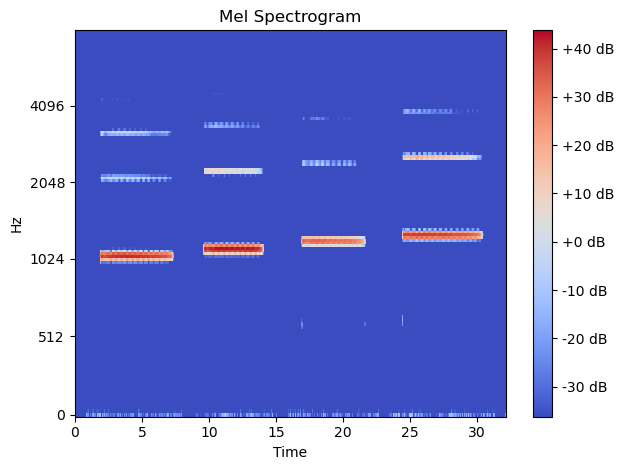

In [6]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.amplitude_to_db(S),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()

In [7]:
data_dir = '/Users/giorgi/Desktop/instrument_dataset/'
Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

In [8]:
# TODO
ntr = Xtr.shape[0] 
nts = Xts.shape[0] 
nin = Xtr.shape[1] 
npm = np.max(ytr)+1
print(ntr,nts,nin,npm)

66247 14904 120 10


In [9]:
# TODO Scale the training and test matrices
# Xtr_scale = ...
# Xts_scale = ...
Xtr_scale = (Xtr-np.mean(Xtr,0))/np.std(Xtr,0)
Xts_scale = (Xts-np.mean(Xtr,0))/np.std(Xtr,0)

In [10]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.backend as K

In [11]:
# TODO clear session
K.clear_session()

In [12]:
# TODO: construct the model
nin = Xtr_scale.shape[1] 
nh = 256 # Number of neurons in the hidden layer
nout = int(np.max(ytr)+1)

# Initializing a sequential model
model = Sequential()
model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(units=nout, activation='softmax', name='output'))

In [13]:
# TODO: Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 256)               30976     
                                                                 
 output (Dense)              (None, 10)                2570      
                                                                 
Total params: 33546 (131.04 KB)
Trainable params: 33546 (131.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# TODO
from tensorflow.keras import optimizers

opt = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [15]:
# TODO
import tensorflow.keras.callbacks

nit = 20 
nepoch_per_it = 50 

class PeriodicPrintLoss(tensorflow.keras.callbacks.Callback):
    def __init__(self, prt_period=100):
        self.prt_period = prt_period
    def on_train_begin(self, logs={}):
        self.losses = []
        self.step = 0
    def on_batch_end(self, batch, logs={}):
        # Record the loss
        loss = logs.get('loss')
        self.losses.append(loss)
        # Print the loss periodically
        if (self.step % self.prt_period == 0):
            print('step=%6d loss=%12.4e' % (self.step, loss))
        self.step += 1
# Compute print period in steps
batch_size = 100
prt_period = nepoch_per_it*int(ntr/batch_size)

# Create the callback
loss_cb = PeriodicPrintLoss(prt_period=prt_period)

# Run the fit with the callback
hist = model.fit(Xtr_scale, ytr, epochs=10, batch_size=batch_size, validation_data=(Xts_scale, yts), 
                 callbacks=[loss_cb])

Epoch 1/10
step=     0 loss=  2.4906e+00
663/663 [==============================] - 1s 2ms/step - loss: 0.3631 - accuracy: 0.9007 - val_loss: 0.1863 - val_accuracy: 0.9461
Epoch 2/10
663/663 [==============================] - 1s 1ms/step - loss: 0.1036 - accuracy: 0.9750 - val_loss: 0.0945 - val_accuracy: 0.9756
Epoch 3/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0610 - accuracy: 0.9853 - val_loss: 0.0657 - val_accuracy: 0.9824
Epoch 4/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0428 - accuracy: 0.9896 - val_loss: 0.0573 - val_accuracy: 0.9858
Epoch 5/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0324 - accuracy: 0.9917 - val_loss: 0.0432 - val_accuracy: 0.9884
Epoch 6/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0256 - accuracy: 0.9933 - val_loss: 0.0324 - val_accuracy: 0.9903
Epoch 7/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0211 - accuracy: 0.9945 - val_loss: 0.0310

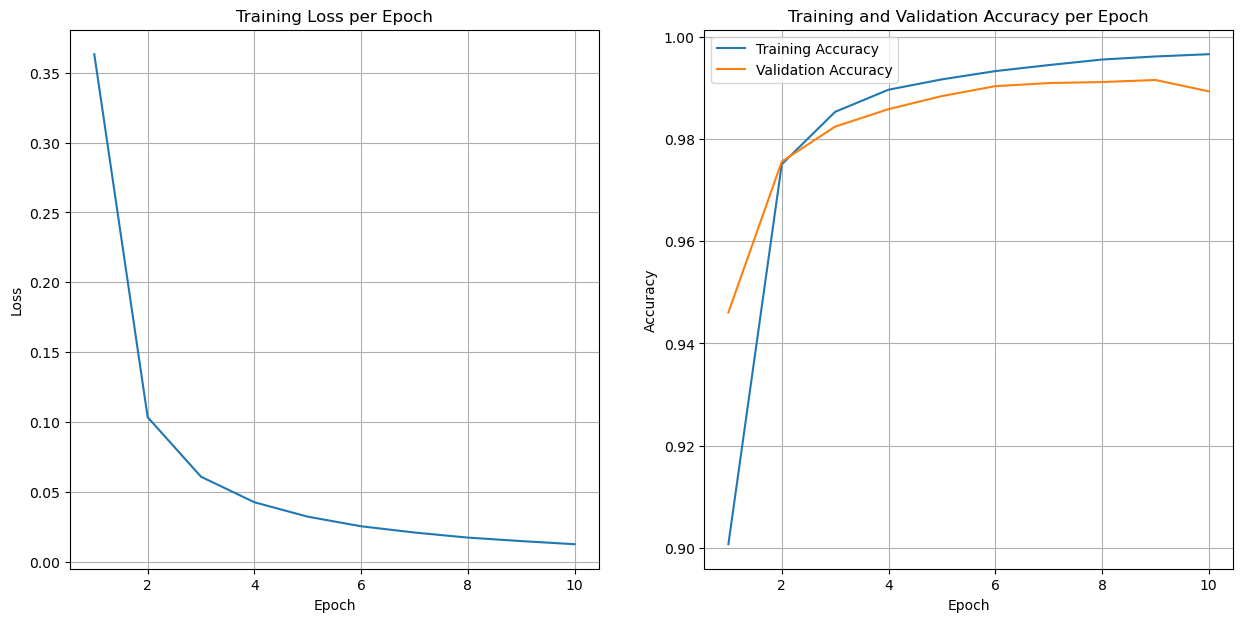

In [16]:
# Extracting loss and accuracy from the model's training history
loss = hist.history['loss']  
acc = hist.history['accuracy']  
val_acc = hist.history['val_accuracy'] 

nepochs = len(loss)  
epochs = np.arange(1, nepochs + 1)  

# Setting up the plot with two subplots in a row
plt.subplots(1, 2, figsize=(15, 7))

# First subplot for loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss)  # Plotting loss vs epochs 
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.grid() 
plt.title('Training Loss per Epoch')  

# Second subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc)  # Plotting training accuracy vs epochs
plt.plot(epochs, val_acc)
plt.xlabel('Epoch')  
plt.ylabel('Accuracy')  
plt.grid() 
plt.title('Training and Validation Accuracy per Epoch') 
plt.legend(['Training Accuracy', 'Validation Accuracy'])  

plt.show() 

Epoch 1/10
663/663 [==============================] - 1s 2ms/step - loss: 0.1108 - accuracy: 0.9664 - val_loss: 0.0442 - val_accuracy: 0.9860
Epoch 2/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0302 - accuracy: 0.9900 - val_loss: 0.0543 - val_accuracy: 0.9822
Epoch 3/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0197 - accuracy: 0.9935 - val_loss: 0.0470 - val_accuracy: 0.9839
Epoch 4/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.0270 - val_accuracy: 0.9901
Epoch 5/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0173 - accuracy: 0.9942 - val_loss: 0.0572 - val_accuracy: 0.9812
Epoch 6/10
663/663 [==============================] - 1s 1ms/step - loss: 0.0142 - accuracy: 0.9954 - val_loss: 0.0468 - val_accuracy: 0.9854
Epoch 7/10
663/663 [==============================] - 1s 2ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.0327 - val_accuracy: 0.9898
Epoch 

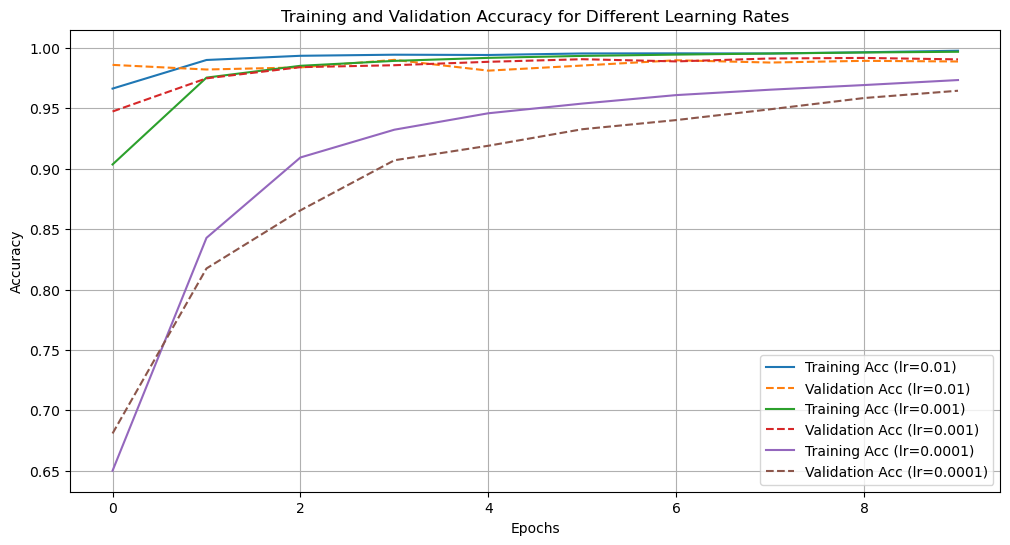

In [17]:
rates = [0.01, 0.001, 0.0001]  
batch_size = 100 
loss_hist = []  
acc_hist = [] 
val_acc_hist = []  

for lr in rates:
    # Clearing the previous model session to start fresh
    K.clear_session()

    # Building the neural network model
    model = Sequential()
    model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
    model.add(Dense(nout, activation='softmax', name='output'))

    # Setting up the optimizer with the current learning rate
    opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Training the model with the current learning rate
    hist = model.fit(Xtr_scale, ytr, epochs=10, batch_size=batch_size, validation_data=(Xts_scale, yts))

    # Appending the training history to respective lists
    loss_hist.append(hist.history['loss'])
    acc_hist.append(hist.history['accuracy'])
    val_acc_hist.append(hist.history['val_accuracy'])

    # Printing the final validation accuracy for the current learning rate
    print(f"lr={lr:12.4e} test accuracy={hist.history['val_accuracy'][-1]:.4f}")

# Plotting the training and validation accuracy for each learning rate
plt.figure(figsize=(12, 6))
for i, lr in enumerate(rates):
    plt.plot(acc_hist[i], label=f'Training Acc (lr={lr})')
    plt.plot(val_acc_hist[i], '--', label=f'Validation Acc (lr={lr})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Different Learning Rates')
plt.legend()
plt.grid()
plt.show()



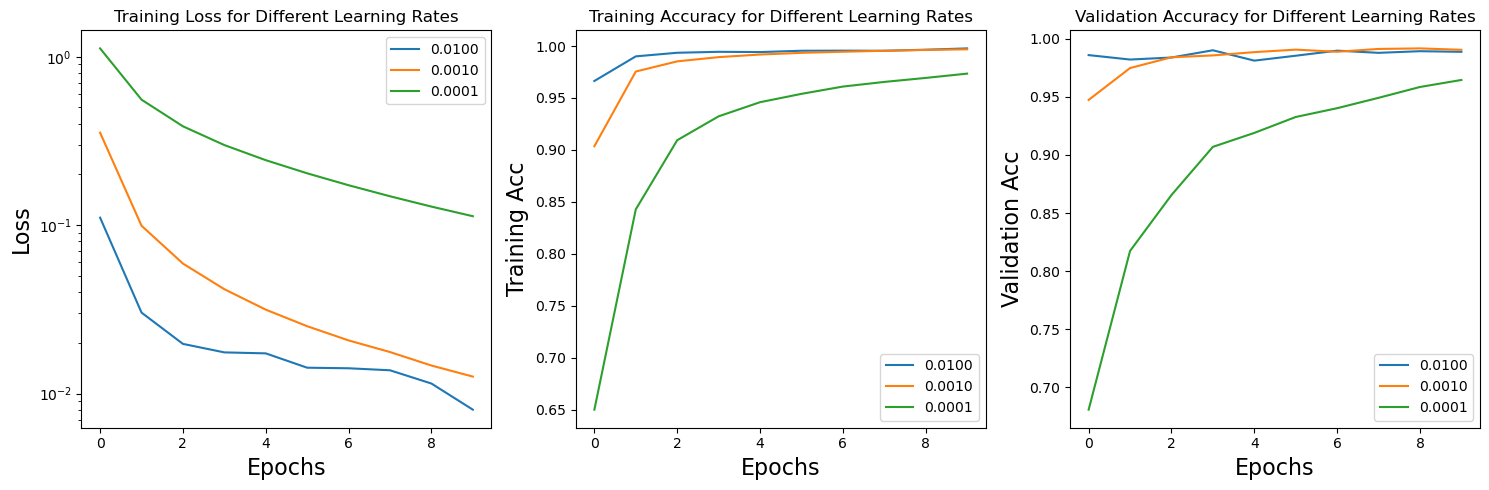

In [18]:
plt.subplots(1, 3, figsize=(15, 5))

# Plotting Loss for each learning rate
plt.subplot(1, 3, 1)
for it, loss in enumerate(loss_hist):
    plt.semilogy(loss) 
rate_str = ['{0:5.4f}'.format(lr) for lr in rates]
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training Loss for Different Learning Rates')  
plt.legend(rate_str, loc='upper right')
plt.tight_layout()

# Plotting Training Accuracy for each learning rate
plt.subplot(1, 3, 2)
for it, acc in enumerate(acc_hist):
    plt.plot(acc)
rate_str = ['{0:5.4f}'.format(lr) for lr in rates]
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training Acc', fontsize=16)
plt.title('Training Accuracy for Different Learning Rates') 
plt.legend(rate_str, loc='lower right')
plt.tight_layout()

# Plotting Validation Accuracy for each learning rate
plt.subplot(1, 3, 3)
for it, val_acc in enumerate(val_acc_hist):
    plt.plot(val_acc)
rate_str = ['{0:5.4f}'.format(lr) for lr in rates]
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Validation Acc', fontsize=16)
plt.title('Validation Accuracy for Different Learning Rates')  
plt.legend(rate_str, loc='lower right')
plt.tight_layout()